# ECON622: Problem Set 4

Jesse Perla, UBC

## Student Name/Number: (doubleclick to edit)

# Packages

Add whatever packages you wish here

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import torch
import jax
import jax.numpy as jnp
from jax import grad, hessian
import torch.nn as nn
import torch.optim as optim
from jax import random
import optax
import jax_dataloader as jdl
from jax_dataloader.loaders import DataLoaderJAX
from flax import nnx
from openai import OpenAI
import wandb
import jsonargparse

## Question 1: W&B Logging and CLI (JAX NNX)

For the linear regression examples with PyTorch we added in
[linear_regression_pytorch_logging.py](../slides/examples/linear_regression_pytorch_logging.py)
logging and a CLI interface — which came for free with PyTorch
Lightning.

In this question you will add in some of those features to the
[linear_regression_jax_nnx.py](../slides/examples/linear_regression_jax_nnx.py)
example.

### Question 1.1: Add W&B Logging

Take the `linear_regression_jax_nnx.py` copied below for your
convenience and:

1.  Setup W&B properly
2.  Add in logging of the `train_loss` at every step of the optimizer
3.  Remove the other epoch printing, or try to log an epoch specific
    `||theta - theta_hat||` if you wish
4.  Log the end `||theta - theta_hat||` at the end of the training

In [2]:
# MODIFY CODE HERE
import jax
import jax.numpy as jnp
from jax import random
import optax
import jax_dataloader as jdl
from jax_dataloader.loaders import DataLoaderJAX
from flax import nnx

N = 500  # samples
M = 2
sigma = 0.001
rngs = nnx.Rngs(42)
theta = random.normal(rngs(), (M,))
X = random.normal(rngs(), (N, M))
Y = X @ theta + sigma * random.normal(rngs(), (N,))  # Adding noise

def residual(model, x, y):
    y_hat = model(x)
    return (y_hat - y) ** 2

def residuals_loss(model, X, Y):
    return jnp.mean(jax.vmap(residual, in_axes=(None, 0, 0))(model, X, Y))

model = nnx.Linear(M, 1, use_bias=False, rngs=rngs)

lr = 0.001
optimizer = nnx.Optimizer(model, optax.sgd(lr), wrt=nnx.Param)

@nnx.jit
def train_step(model, optimizer, X, Y):
    def loss_fn(model):
        return residuals_loss(model, X, Y)
    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(model, grads)
    return loss


num_epochs = 1000
batch_size = 512
dataset = jdl.ArrayDataset(X, Y)
train_loader = DataLoaderJAX(dataset, batch_size=batch_size, shuffle=True)
for epoch in range(num_epochs):
    for X_batch, Y_batch in train_loader:
        loss = train_step(model, optimizer, X_batch, Y_batch)

    if epoch % 100 == 0:
        print(
            f"Epoch {epoch},||theta - theta_hat|| = {jnp.linalg.norm(theta - jnp.squeeze(model.kernel.value))}"
        )

print(f"||theta - theta_hat|| = {jnp.linalg.norm(theta - jnp.squeeze(model.kernel.value))}")

### Question 1.2: Add CLI Interface

Now, take the above code and copy it into a file named
`linear_regression_jax_cli.py`.

We want to make it CLI ready:

-   A package with many features, most of which you wouldn’t use
    directly, is [jsonargparse](https://jsonargparse.readthedocs.io/).
    Besides the more advanced features like [configuration
    files](https://jsonargparse.readthedocs.io/en/v4.26.2/#writing-configuration-files)
    and the instantiation of classes/etc. as arguments, the main
    difference will be that it checks the types of arguments and
    converts them for you using python typehints.
-   Alternatively, you can use the builtin
    [Argparse](https://docs.python.org/3/library/argparse.html) or any
    other [CLI
    framework](https://github.com/shadawck/awesome-cli-frameworks#python)

In that case, you can adapt the following code for your
`linear_regression_jax_cli.py`:

    import jsonargparse
    def main_fn(lr: float = 0.001, N: int = 100):
        print(f"lr = {lr}, N = {N}")

    if __name__ == "__main__":
         jsonargparse.CLI(main_fn)

#### Using your CLI

In either case, at that point you should be able to call this with
`python linear_regression_jax_cli.py` and have it use all of the default
values, `python linear_regression_jax_cli.py --N=200` to change them,
etc.

Either submit the file as part of the assignment or just paste the code
into the notebook.

### Question 1.3 (BONUS): W&B Sweep

Given the CLI you can now run a hyperparameter search. For this bonus
problem, do a hyperparameter search over the `--lr` argument by
following the [W&B documentation](https://docs.wandb.ai/guides/sweeps).

To get you started, your sweep YAML might look something like this:

``` {yaml}
program: linear_regression_jax_cli.py
name: JAX Example
project: linear_regression_jax
description: JAX Sweep
method: random
parameters:
  lr:
    min: 0.0001
    max: 0.01
```

Here the `method` is changed from Bayes to
[`random`](https://docs.wandb.ai/guides/sweeps/define-sweep-configuration#method)
because otherwise we would need to provide a `metric` to optimize over.
Feel free to adapt any of these settings.

If you successfully run a sweep then paste in your own YAML file here,
and a screenshot of the W&B dashboard showing something about the sweep
results.

## Question 2: PyTorch Neural Networks

In the repository you have code that does a linear regression with
PyTorch:
[linear_regression_pytorch_sgd.py](../slides/examples/linear_regression_pytorch_sgd.py).

### Question 2.1: Shallow MLP

Make a new file that does the same thing, but replace the
`nn.Linear(M, 1, bias=False)` with code that gives a neural network with
multiple layers. Maybe try:

In [6]:
M = 2 # loaded automatically in the code
num_width = 8 # etc.  You can hardcode or add to the template/yaml code
nn.Sequential(
    nn.Linear(M, num_width),
    nn.ReLU(),
    nn.Linear(num_width, 1, bias = False)
)

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=1, bias=False)
)

This is a network with one “hidden” layer. Try this for a very shallow
network (e.g. `num_width = 8`) and see if it converges with Adam or SGD.
It is OK if it does not! Don’t spend too much time with it.

### Question 2.2: Deep MLP

Now replace this with a deeper and wider network by the same pattern.
Maybe something like:

In [8]:
M = 2 # loaded automatically in the code
num_width = 256 # etc.  You can hardcode or add to the template/yaml code
nn.Sequential(
    nn.Linear(M, num_width),
    nn.ReLU(),
    nn.Linear(num_width, num_width),
    nn.ReLU(),
    nn.Linear(num_width, num_width),
    nn.ReLU(),
    nn.Linear(num_width, num_width),
    nn.ReLU(),
    nn.Linear(num_width, 1, bias = False)
)

Sequential(
  (0): Linear(in_features=2, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=256, bias=True)
  (7): ReLU()
  (8): Linear(in_features=256, out_features=1, bias=False)
)

Try to optimize this now and see if it fits well with this deeper
network. If this is too slow, change the `num_width` or remove a layer
to see if it helps.

### Question 2.3 (BONUS): Nonlinear DGP

The above is trying to fit a linear DGP. Instead, increase the dimension
`M` to something much larger, and modify the DGP to be something
nonlinear. Try out the larger network to see if it fits it well.

## Question 3 (BONUS): JAX NNX Neural Networks

Now we can try the same thing with JAX and NNX using
[linear_regression_jax_nnx.py](../slides/examples/linear_regression_jax_nnx.py).

### Question 3.1

Take the code and modify the network from the simple
`nnx.Linear(M, 1, use_bias=False, rngs=rngs)` to do a nonlinear function
with more parameters and layers, as in Question 2.2.

There is no builtin MLP in `nnx`, but you can construct it manually by
creating a class from `nnx.Module` and then nesting calls to
`nnx.Linear` with an activation like `nnx.relu`. See [the
docs](https://flax.readthedocs.io/en/latest/mnist_tutorial.html#define-the-model-with-flax-nnx)
for more information.

## Question 4: GP Regression (GPyTorch)

The following code comes from the
[GPyTorch](https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html)
documentation.

Iter 1/50 - Loss: 0.940   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.908   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.874   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 0.836   lengthscale: 0.555   noise: 0.554
Iter 5/50 - Loss: 0.794   lengthscale: 0.514   noise: 0.513
Iter 6/50 - Loss: 0.746   lengthscale: 0.475   noise: 0.474
Iter 7/50 - Loss: 0.695   lengthscale: 0.439   noise: 0.437
Iter 8/50 - Loss: 0.643   lengthscale: 0.404   noise: 0.402
Iter 9/50 - Loss: 0.593   lengthscale: 0.372   noise: 0.369
Iter 10/50 - Loss: 0.547   lengthscale: 0.342   noise: 0.339
Iter 11/50 - Loss: 0.507   lengthscale: 0.315   noise: 0.310
Iter 12/50 - Loss: 0.469   lengthscale: 0.292   noise: 0.284
Iter 13/50 - Loss: 0.434   lengthscale: 0.272   noise: 0.259
Iter 14/50 - Loss: 0.399   lengthscale: 0.256   noise: 0.237
Iter 15/50 - Loss: 0.365   lengthscale: 0.243   noise: 0.216
Iter 16/50 - Loss: 0.332   lengthscale: 0.232   noise: 0.196
Iter 17/50 - Loss: 0.299   length

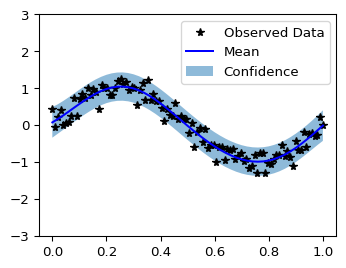

In [12]:
import math
import torch
import gpytorch
from gpytorch.kernels import ScaleKernel, RBFKernel, LinearKernel
from matplotlib import pyplot as plt
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

### Question 4.1: Different Kernel

Using the code above, try a different kernel from [the
docs](https://docs.gpytorch.ai/en/stable/kernels.html) and plot the
results. Doesn’t matter if it is better or worse, but you should try to
pick a kernel that has different parameters to fit.

### Question 4.2 (BONUS): Noiseless GP Interpolation

Now take the code above:

1.  Remove the noise in the DGP
2.  Decrease the number of generated datapoints to maybe 10 or so.
3.  Try to see how to fit a GP without any observational noise, so that
    it interpolates the data. This may require changing the likelihood
    object in the loop above.

## Question 5: OpenAI API

Setting up OpenAI to access ChatGPT and embeddings programmatically.

### Question 5.1: Setup and First Call

Setup an account on the [OpenAI platform](https://platform.openai.com/):

-   Sign up
-   Go to the `API keys` tab and create a key
-   In your terminal, set `OPENAI_API_KEY` to this value (see
    [here](https://platform.openai.com/docs/quickstart?desktop-os=macOS#create-and-export-an-api-key))

Given the change in the environment variable, you may need to restart
your browser/editor/etc.

Get the following code running, which shows a prompt:

In [15]:
client = OpenAI()
completion = client.chat.completions.create(
    model="gpt-4o-mini",
    temperature=0.7, max_tokens=300, #optional
    messages=[
        {
          "role": "system",
          "content": "You are generating numbers that are easy to parse."
        },
        {
          "role": "user",
          "content": "Give me a list of 3 numbers"
        }
    ]
)
print(completion.choices[0].message.content)

### Question 5.2: Temperature Exploration

Take that prompt and run it a bunch of times with `temperature = 0.0`.
What happens and why?

Next, run it a bunch of times with `temperature = 2.0`, which is the
maximum entropy. What happens and why?

### Question 5.3: Parsing LLM Output

Modify the `system` role in that prompt until you can easily parse the
`completion.choices[0].message.content` into a list, reliably, with
`temperature = 0.7`.

In [17]:
client = OpenAI()
completion = client.chat.completions.create(
    model="gpt-4o-mini",
    temperature=0.7,
    messages=[
        {
          "role": "system",
          "content": "You are generating numbers that are easy to parse." #modify this
        },
        {
          "role": "user",
          "content": "Give me a list of 3 numbers"
        }
    ]
)
print(completion.choices[0].message.content)
# Add parsing logic